# Style transfer with Deep Neural Networks

## Introduction

Convolutional neural networks, a special type of neural network primerally used in computer vision, are compositional.

It means that the early layers in the network tends to learn simple features like edges, colour and texture, while deeper layers learn more complex shapes which are a composition of the previous, simple features.

What if we take two images, one with the content and the other one with the style, to output a third one with the content from the first image and the style from the second image?

![example](https://godatadriven.com/wp-content/images/how-to-style-transfer/style-transfer-example.jpg)

## How does it works? Maths!

![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

A neural network is a function, like any mathematical function, it as an input and an output.  
In computer vision, it takes an image as an input, and most of the time, tries to classifies it by outputting the category it belongs to. 

In our case, we want to modify the content image, such as the early layers looks like the style image, and the last layers looks like the style image.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

We use VGG19 pretrained on ImageNet to define the style and content extractor

In [2]:
class VGGFeatureExtractor(nn.Module):
    # Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch
    # modified with vgg19
    def __init__(self):
        super(VGGFeatureExtractor,self).__init__()
        self.features = torchvision.models.vgg19(pretrained=True).features
        
        # making this model's parameters untrainable
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self, x, layerIndices):
        outputs = list()  #outputs from the selected layers
        
        # for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) # apply the layer
            
            # if this layer is a desired layer, store its outputs
            if i in layerIndices:
                outputs.append(x)
                
                # check if we got all desired layers
                if i == layerIndices[-1]:
                    return outputs
                    
        return outputs

feature_extractor = VGGFeatureExtractor()


/Users/ingambe/miniforge3/envs/deep-learning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ingambe/miniforge3/envs/deep-learning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Bottom layers contains the style, while the top layers are very specific and match the content of the image

In [3]:
content_layers = [25, 28]
style_layer = [0, 5, 10, 19]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

## Let's make it work! 

Let's try to take a picture of Klagenfurt and add the style of picture on top of it.


<table><tr><td><img src='https://imgl.krone.at/scaled/2093570/vddd60f/full.jpg' width="515"></td><td><img src='https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/starry_night_google.jpg' width="555"></td></tr></table>


In [5]:
from PIL import Image
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  485k  100  485k    0     0  2598k      0 --:--:-- --:--:-- --:--:-- 2682k


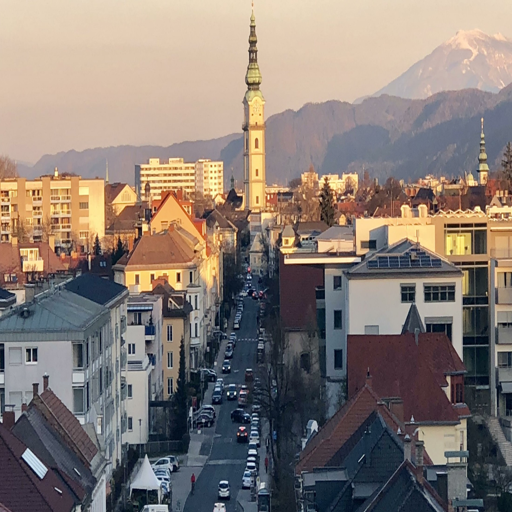

In [6]:
!curl --output cat.jpeg "https://imgl.krone.at/scaled/2093570/vddd60f/full.jpg"
content_image = Image.open('cat.jpeg').resize((512, 512))
content_image

In [7]:
content_im_tensor = torch.tensor(np.array(content_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
target_content_features = feature_extractor(content_im_tensor, content_layers)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  598k  100  598k    0     0  1391k      0 --:--:-- --:--:-- --:--:-- 1412k


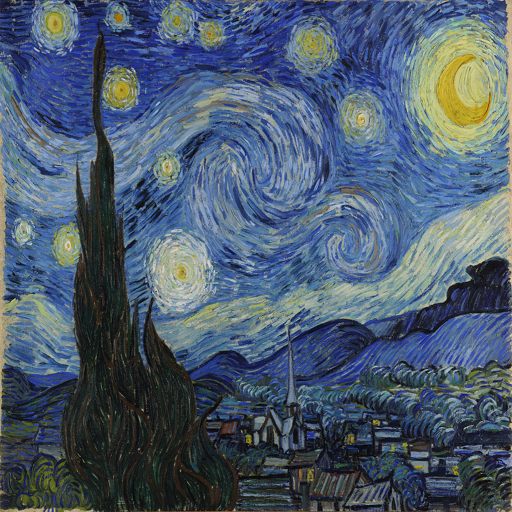

In [8]:
!curl --output style.jpeg "https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/starry_night_google.jpg"
style_image = Image.open('style.jpeg').resize((512, 512))
style_image

In [9]:
style_im_tensor = torch.tensor(np.array(style_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
target_style_features = feature_extractor(style_im_tensor, style_layer)

#### Content loss

The idea is to preserve the content of the image (i.e., the output of the content layers needs to stay very similar from the beginning to the end of the training).

In [10]:
def content_loss(im, target_content_features):
    im_content_features = feature_extractor(im, content_layers)
    loss = 0
    for im_features, target_features in zip(im_content_features, target_content_features):
        loss += nn.L1Loss()(im_features, target_features)
    return loss/len(im_content_features)

im = torch.rand(1, 3, 512, 512).to(device)
content_loss(im, target_content_features)

tensor(1.5128)

#### Style loss

While the output of the style layers of the input image need to match the output of style layers on the style image.  
We modify the input image by backpropagating the gradient on the input image.

In [11]:
def gram(x):
    #CNNs express locality, the gram matrix prevents this
    b,c,h,w = x.size();
    x = x.view(b*c, -1);
    return torch.mm(x, x.t())/(h*w)
 
def style_loss(im, target_style_features):
    im_style_features = feature_extractor(im, style_layer)
    loss = 0
    for im_features, target_features in zip(im_style_features, target_style_features):
        im_gram = gram(im_features)
        target_gram = gram(target_features)
        loss += F.mse_loss(im_gram, target_gram);
    return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(191.3882)

### Training Loop

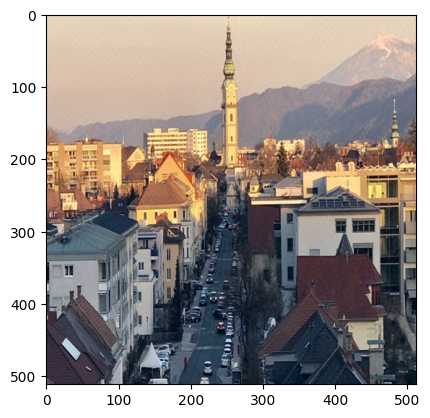

Loss at epoch 0: 87.93414306640625


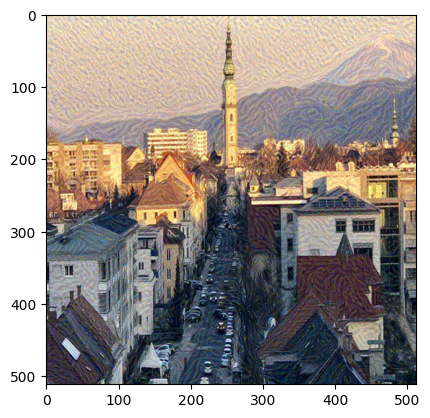

Loss at epoch 100: 0.9976399540901184



KeyboardInterrupt



In [12]:
im = torch.tensor(np.array(content_image)/255., dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
im.requires_grad = True

optimizer = torch.optim.Adam([im], lr=8e-3)

# Weights we'll give to the different losses
style_weight, content_weight = 0.5, 1

losses = [] 
for i in range(1000):
    optimizer.zero_grad()  
    loss = style_weight * style_loss(im.clip(0, 1), target_style_features)
    loss += content_weight * content_loss(im.clip(0, 1), target_content_features)
    loss.backward() 
    optimizer.step()
    
    losses.append(loss.item())
    # Showing the progress occasionally
    if i % 100 == 0:
        plt.imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
        plt.show()
        print(f'Loss at epoch {i}: {loss.item()}')

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

In [ ]:
plt.imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
plt.savefig('output.png')